In [2]:
import numpy as np
import numpy.linalg as LA
from sklearn.utils import murmurhash3_32
from random import randint
import matplotlib.pyplot as plt
import stats
import copy
import time
import multiprocessing
from Functions import *
from scipy.special import factorial
import math
from scipy.stats import poisson
from scipy.stats import norm
from scipy.stats import binom
from scipy.integrate import quad
from scipy.stats import multivariate_normal
from scipy.stats import mvn
from scipy.optimize import fsolve

In [3]:
def hashfunc(m):
    ss = randint(1, 99999999)
    def hash_m(x):
        return murmurhash3_32(x,seed=ss)%m
    return hash_m


class count_sketch():
    def __init__(self, n, k):
        self.n = n
        self.k = k
        self.table = np.zeros((n,k))
        self.hash_func = [hashfunc(n) for i in range(int(k))]
        self.sign_hash = [hashfunc(2) for i in range(int(k))]
        self.item_count = 0
        
    def insert(self, item, index):
        loc = np.array([self.hash_func[k](index) for k in range(self.k)])
        sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k)])
        self.table[loc,np.arange(self.k)] += item * sign
        self.item_count += 1
        
    def insert_ID_list(self, item, index):
        index = index.reshape((len(index), 1))
        loc_array = np.apply_along_axis(lambda x: [Hash(x[0]) for Hash in sketch.hash_func], 1, index)
        sign_array = np.apply_along_axis(lambda x: [(-1)**Hash(x[0]) for Hash in sketch.sign_hash], 1, index)
        for i in range(loc_array.shape[0]):      
            self.table[loc_array[i],np.arange(self.k)] += item[i] * sign_array[i]
        
    def retrieve(self, index):
        loc = np.array([self.hash_func[k](index) for k in range(self.k)])
        sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k)])
        items = self.table[loc,np.arange(self.k)]*sign
        return np.median(items)
    
    def retrieve_ID_list(self, index):
        index = index.reshape((len(index), 1))
        loc_array = np.apply_along_axis(lambda x: [Hash(x[0]) for Hash in sketch.hash_func], 1, index)
        sign_array = np.apply_along_axis(lambda x: [(-1)**Hash(x[0]) for Hash in sketch.sign_hash], 1, index)
        item_array = self.table[loc_array.flatten(), np.tile(np.arange(self.k), loc_array.shape[0])]
        item_array = item_array.reshape(loc_array.shape) * sign_array
        return np.median(item_array, axis = 1)
    
    def retrieve_item_list(self, index, VAR = False):
        loc = np.array([self.hash_func[k](index) for k in range(self.k)])
        sign = np.array([(-1)**(self.sign_hash[k](index)) for k in range(self.k)])
        items = self.table[loc,np.arange(self.k)]*sign
        if VAR:
            item_var = np.var(np.sort(item_list)[3:(self.k-3)])
            return items, item_var
        else:
            return items

    
    def clean():
        self.table = np.zeros((n,k))
        self.item_count = 0
        
        
        
def parallel_apply_along_axis(func1d, axis, arr):
    """
    Like numpy.apply_along_axis(), but takes advantage of multiple
    cores.
    """        
    # Effective axis where apply_along_axis() will be applied by each
    # worker (any non-zero axis number would work, so as to allow the use
    # of `np.array_split()`, which is only done on axis 0):
    effective_axis = 1 if axis == 0 else axis
    if effective_axis != axis:
        arr = arr.swapaxes(axis, effective_axis)

    # Chunks for the mapping (only a few chunks):
    chunks = [(func1d, effective_axis, sub_arr)
              for sub_arr in np.array_split(arr, multiprocessing.cpu_count())]

    pool = multiprocessing.Pool()
    individual_results = pool.map(unpacking_apply_along_axis, chunks)
    # Freeing the workers:
    pool.close()
    pool.join()

    return np.concatenate(individual_results)



## Simulate data with large noise

In [4]:
p = 10**5
n = 1000
signal = 1
num_signal = int(0.001*p)

mu = np.zeros(p)
mu[0:num_signal] = signal

sigma_1 = 3
sigma_2 = 3

x1 = np.random.normal(0, sigma_1, (n*(p-num_signal)))
x1 = x1.reshape((n,(p-num_signal)))

x2 = np.random.normal(0, sigma_2, (n*num_signal))
x2 = x2.reshape((n,num_signal))

x = np.concatenate((x2, x1), axis = 1)

def my_func(a, mu = mu):
    return a + mu

x = np.apply_along_axis(my_func, 1, x)

ID = [id(a) for a in range(p)]
ID = np.array([str(x) for x in ID])

## Apply CMS to select the heavy hitters

In [18]:
block_end = list(np.arange(500, n, 1)) + [n]
block_start = [0] + block_end[:-1]
halflife = 200


sketch = count_sketch(int(p/20), 5)
sketch.clean

median_list = []

N = 1000

for i, (start, end) in enumerate(zip(block_start, block_end)):
    x_batch = x[start:end,:]
    mean_batch = np.apply_along_axis(np.sum, 0, x_batch)/N
    
    ## Filtering
    if (i > 0):
        mean_batch = mean_batch[index_retain]
        ID_retain = np.array(ID)[index_retain]     
    else:
        index_retain = (np.ones(len(ID))>0)
        ID_retain = ID
    
    # ID_retain = ID
    
    sketch.insert_ID_list(mean_batch, ID_retain)
    
    ## Retrieve
    mean_2 = sketch.retrieve_ID_list(ID)
        
    mean_prod_2 = []
    for mem_id in ID:
        item_list = np.sort(sketch.retrieve_item_list(mem_id))
        mean_prod_2 += [np.prod(item_list[1:(sketch.k-1)])]

    
    # thres_ratio = 0.5*2**(-(end - block_end[0])/halflife)
    
    # thres_ratio = 0.5
    # median_entry = np.quantile(np.abs(mean_2), 1 - thres_ratio)

    median_entry = 0.12 + 0.3*i/N
        
    median_list += [median_entry]
    index_retain = (np.abs(mean_2) > median_entry)

    
    if (end > 400) and (end % 100 == 0):
        print(end)
        
    # print(median_entry, num_signal-np.sum(index_retain[0:num_signal]))
    
    if (end > 400) and (end % 10 == 0):
        print(round(median_entry, 5), p-num_signal-np.sum(index_retain[num_signal:]), num_signal-np.sum(index_retain[0:num_signal]))



500
0.12 50922 3
0.123 54377 3
0.126 56675 3
0.129 58705 3
0.132 60326 3
0.135 61604 2
0.138 62995 4
0.141 64230 4
0.144 65379 5
0.147 66599 4
600
0.15 67498 4
0.153 68454 4
0.156 69326 4
0.159 70316 4
0.162 71228 4
0.165 72013 4
0.168 72920 4
0.171 73695 4
0.174 74514 4
0.177 75222 5
700
0.18 75959 5
0.183 76513 5
0.186 77101 5
0.189 77755 4
0.192 78383 4
0.195 78918 4
0.198 79538 4
0.201 80260 4
0.204 80729 4
0.207 81322 4
800
0.21 81710 4
0.213 82301 4
0.216 82741 4
0.219 83079 4
0.222 83505 4
0.225 83972 4
0.228 84324 4
0.231 84629 4
0.234 85191 4
0.237 85600 4
900
0.24 85978 4
0.243 86323 4
0.246 86619 4
0.249 87045 4
0.252 87415 4
0.255 87738 4
0.258 88086 4
0.261 88496 4
0.264 88721 4
0.267 89083 4
1000
0.27 89295 4


In [5]:
# bins = np.linspace(-1, 1.5, 50)
# plt.hist(mean_2[num_signal:], alpha = 0.5, bins = bins)
# plt.hist(mean_2[0:num_signal], alpha = 0.5, bins = bins)
# # plt.yscale('log')
# plt.show()

# thres = np.linspace(0.6, 1, 100)
# plt.plot(thres, [np.sum(np.abs(mean_2[num_signal:])>a) for a in thres])
# plt.title('Tail Probability of Noise Arms')
# plt.show()

In [6]:
# plt.hist(mean_2[num_signal:], bins=50)
# plt.title('Distribution of Noise Arms (Without Sampling)')
# plt.savefig('./Figures/Distribution of Noise Arms (Without Sampling).png')
# plt.show()

In [7]:
# plt.hist(mean_2[num_signal:], bins=50)
# plt.title('Distribution of Noise Arms (With Sampling)')
# plt.savefig('./Figures/Distribution of Noise Arms (With Sampling).png')
# plt.show()

Best F1 Score:  0.75


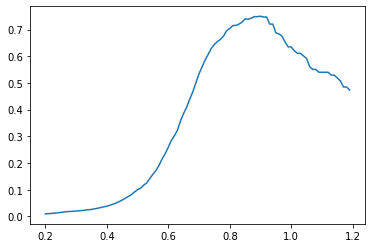

In [19]:
F1_score = []
precision_list = []
recall_list = [] 


threshold_list = np.arange(0.2, 1.2, 0.01)

# threshold_list = np.arange(0.1, 1, 0.01)
for thres in threshold_list:
    positive_index = (np.abs(mu)>0)
    predict_positive_index = (np.abs(mean_2)>thres)
    fn = np.sum(positive_index*(1-predict_positive_index))
    tp = np.sum(predict_positive_index*positive_index)
    
    precision = tp/np.sum(predict_positive_index)
    recall = tp/(tp+fn)
    
    ## Deviation from the true covariance matrix
    F1_score += [2*precision*recall/(precision+recall)]
    precision_list += [precision]
    recall_list += [recall]
    
    
print('Best F1 Score: ', np.max(F1_score))

plt.plot(threshold_list, F1_score)
plt.show()

# plt.plot(threshold_list, precision_list)
# plt.show()

# plt.plot(threshold_list, recall_list)
# plt.show()

# plt.plot(1 - np.array(precision_list), np.array(recall_list))
# plt.xlabel('1 - Precision')
# plt.ylabel('Recall')
# plt.show()

Best F1 Score:  0.8125


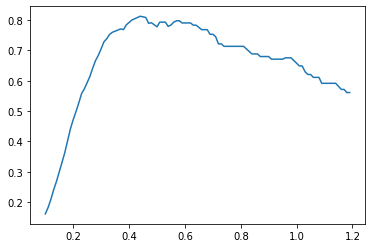

In [22]:
F1_score_3 = []
precision_list_3 = []
recall_list_3 = [] 


mean_prod_2 = []
mean_sum_2 = []

for mem_id in ID:
    item_list = np.sort(sketch.retrieve_item_list(mem_id))
    mean_prod_2 += [np.prod(item_list[1:(sketch.k-1)])]
    mean_sum_2 += [np.mean(item_list[1:(sketch.k-1)])]
    
threshold_list = np.arange(0.1, 1.2, 0.01)

# threshold_list = np.arange(0.1, 1, 0.01)
for thres in threshold_list:
    positive_index = (np.abs(mu)>0)
    # predict_positive_index = (np.abs(mean_prod_2)>thres)
    predict_positive_index = (np.abs(mean_prod_2)>thres)
    fn = np.sum(positive_index*(1-predict_positive_index))
    tp = np.sum(predict_positive_index*positive_index)
    
    precision = tp/np.sum(predict_positive_index)
    recall = tp/(tp+fn)
    
    ## Deviation from the true covariance matrix
    F1_score_3 += [2*precision*recall/(precision+recall)]
    precision_list_3 += [precision]
    recall_list_3 += [recall]
    
    
print('Best F1 Score: ', np.max(F1_score_3))

plt.plot(threshold_list, F1_score_3)
plt.show()

# plt.plot(threshold_list, precision_list_3)
# plt.show()

# plt.plot(threshold_list, recall_list_3)
# plt.show()

# plt.plot(1 - np.array(precision_list_3), np.array(recall_list_3))
# plt.xlabel('1 - Precision')
# plt.ylabel('Recall')
# plt.show()

## Apply traditional CMS to select the heavy hitters

In [23]:
p = 10**5
n = 1000
signal = 1
num_signal = int(0.001*p)

mu = np.zeros(p)
# mu[0:num_signal] = np.random.uniform(1, 1.5, num_signal)
mu[0:num_signal] = np.random.uniform(signal-0.5, signal+0.5, num_signal)

sigma_1 = 3
sigma_2 = 3

x1 = np.random.normal(0, sigma_1, (n*(p-num_signal)))
x1 = x1.reshape((n,(p-num_signal)))

x2 = np.random.normal(0, sigma_2, (n*num_signal))
x2 = x2.reshape((n,num_signal))

x = np.concatenate((x2, x1), axis = 1)

def my_func(a, mu = mu):
    return a + mu

x = np.apply_along_axis(my_func, 1, x)

ID = [id(a) for a in range(p)]
ID = np.array([str(x) for x in ID])

In [24]:
sketch = count_sketch(int(p/20), 5)
print(sketch.table.shape)

sketch.clean

mean_obs = np.apply_along_axis(np.mean, 0, x)
for item, mem_id in zip(mean_obs, ID):
    sketch.insert(item, mem_id)

mean_2 = []
for mem_id in ID:
    mean_2 += [sketch.retrieve(mem_id)]
    
mean_trim_2 = []
# mean_sign_2 = []
for mem_id in ID:
    item_list = np.sort(sketch.retrieve_item_list(mem_id))
    mean_trim_2 += [np.mean(item_list[1:(sketch.k-1)])]
    # mean_sign_2 += [np.sum(np.sign(item_list))]

(5000, 5)


In [13]:
# bins = np.linspace(-1, 1.5, 50)
# plt.hist(mean_2[num_signal:], alpha = 0.5, bins = bins)
# plt.hist(mean_2[0:num_signal], alpha = 0.5, bins = bins)
# plt.yscale('log')
# plt.show()

# thres = np.linspace(0.7, 1, 100)
# plt.plot(thres, [np.sum(np.abs(mean_2[num_signal:])>a) for a in thres])
# plt.title('Tail Probability of Noise Arms')

Best F1 Score:  0.5512820512820512


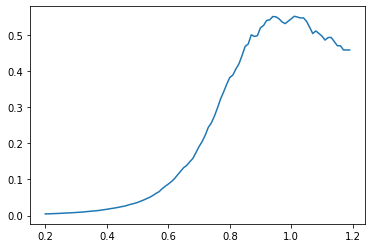

In [25]:
F1_score = []
precision_list = []
recall_list = []
    
threshold_list = np.arange(0.2, 1.2, 0.01)
for thres in threshold_list:
    positive_index = (np.abs(mu)>0)*1
    predict_positive_index = (np.abs(mean_2)>thres)
    fn = np.sum(positive_index*(1-predict_positive_index))
    tp = np.sum(predict_positive_index*positive_index)
    precision = tp/np.sum(predict_positive_index)
    recall = tp/(tp+fn)
    
    ## Deviation from the true covariance matrix
    F1_score += [2*precision*recall/(precision+recall)]
    precision_list += [precision]
    recall_list += [recall]

    
print('Best F1 Score: ', np.max(F1_score))
plt.plot(threshold_list, F1_score)
plt.show()

# plt.plot(threshold_list, precision_list)
# plt.show()

# plt.plot(threshold_list, recall_list)
# plt.show()

# plt.plot(1 - np.array(precision_list), np.array(recall_list))
# plt.xlabel('1 - Precision')
# plt.ylabel('Recall')
# plt.show()

## Threshold based on the full information

1.0


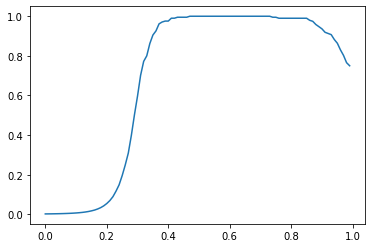

In [11]:
x_mean = np.apply_along_axis(np.mean,0, x)

F1_score_2 = []
precision_list_2 = []
recall_list_2 = [] 

threshold_list = np.arange(0, 1, 0.01)

for thres in threshold_list:
    ## Threshold the small entries of var_obs
    mean_thres = copy.copy(x_mean)
    mean_thres[np.abs(mean_thres)<=thres] = 0
    
    positive_index = (np.abs(mu)>0)*1
    predict_positive_index = (np.abs(mean_thres)>0)*1
    fn = np.sum(positive_index*(1-predict_positive_index))
    tp = np.sum(predict_positive_index*positive_index)
    precision = tp/np.sum(predict_positive_index)
    recall = tp/(tp+fn)
    
    ## Deviation from the true covariance matrix
    F1_score_2 += [2*precision*recall/(precision+recall)]
    precision_list_2 += [precision]
    recall_list_2 += [recall]

max_F1 = np.max(F1_score_2)
print(max_F1)
plt.plot(threshold_list, F1_score_2)
plt.show()

# plt.plot(threshold_list, precision_list_2)
# plt.show()

# plt.plot(threshold_list, recall_list_2)
# plt.show()